# Matrix-Scaling: A Bayesian approach

In [1]:
import os
import sys
import time
import importlib
import collections
sys.path.append('..')

import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt

from utils.data import get_cifar10, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from calibrators import NiceCalibrator, TempScalingCalibrator, MatrixScalingCalibrator

In [2]:
data_path = '../cifar-10'

In [3]:
cifar10, ix2label = get_cifar10(data_path, test=True)
print("Number of samples in the test set: {:d}".format(cifar10["test_labels"].shape[0]))

Number of samples in the test set: 10000


In [4]:
target = onehot_encode(cifar10['test_labels'])

# val/test split
random_split = np.random.permutation(10000)

val_target = target[random_split[:5000], :]
test_target = target[random_split[5000:], :]

In [5]:
resnet_path = '../pretrained-models'
net = 'resnet56_v2'

In [6]:
_, logits = load_logits(os.path.join(resnet_path, net))

# val/test split
val_logits = logits[random_split[:5000], :]
test_logits = logits[random_split[5000:], :]

Initialize params

In [7]:
w_mean = np.random.randn(10, 10)
w_log_var = np.random.randn(10, 10)

b_mean = np.random.randn(10)
b_log_var = np.random.randn(10)

params = {
    'w_mean': w_mean,
    'w_log_var': w_log_var,
    'b_mean': b_mean,
    'b_log_var': b_log_var
}

## PRIOR
prior_w_mean = np.zeros([10, 10])
prior_b_mean = np.zeros(10)

prior_w_log_var = np.log(np.zeros([10, 10]) + 0.0001)
prior_b_log_var = np.log(np.zeros(10) + 0.0001)

In [8]:
def sample(params):
    Z_w = np.random.randn(10, 10)
    Z_b = np.random.randn(10)
    
    w = Z_w*np.exp(0.5 * params['w_log_var']) + params['w_mean']
    b = Z_b*np.exp(0.5 * params['b_log_var']) + params['b_mean']

    return w, b, Z_w, Z_b

In [9]:
def predict(X, params, K=1000):
    y = np.zeros(X.shape)
    for i in range(K):
        w, b, _, _ = sample(params)
        y += X @ w + b
        
    y /= K
    return softmax(y, axis=1)

In [10]:
def KL(params):
    mean_w_KL = 0.5 * np.mean(np.exp(params['w_log_var']-prior_w_log_var) + (prior_w_mean - params['w_mean'])**2 - 1 + (prior_w_log_var - params['w_log_var']))
    mean_b_KL = 0.5 * np.mean(np.exp(params['b_log_var']-prior_b_log_var) + (prior_b_mean - params['b_mean'])**2 - 1 + (prior_b_log_var - params['b_log_var']))
    
    KL = (mean_w_KL + mean_b_KL)/2.
    
    return KL

In [11]:
def fit(X, y, params, batch_size=16, epochs=1000, lambd=0.1, learning_rate=0.001):
    n_steps = X.shape[0]//batch_size + (X.shape[0]%batch_size > 0)
    
    history = {
        'NLL': [],
        'mean_KL': [],
        'ELBO': [],
        'epoch': []
    }
    
    for e in range(epochs):
        for j in range(n_steps):
            
            log_batch = X[j*batch_size:min((j+1)*batch_size, X.shape[0]), :]
            y_batch = y[j*batch_size:min((j+1)*batch_size, X.shape[0]), :]
            
            # Forward pass
            w, b, Z_w, Z_b = sample(params)
            logits = log_batch @ w + b
            
            probs = softmax(logits, axis=1)
            
            # Likelihood backpropagation
            dW = np.mean((probs-y_batch).reshape([-1, 10, 1])
                         @ log_batch.reshape([-1, 1, 10]), axis=0).T
            dw_log_var = dW * (-0.5) * np.exp(0.5 * params['w_log_var']) * Z_w
            dw_mean = dW
            
            db = np.mean((probs-y_batch), axis=0)
            db_log_var = db * (-0.5) * np.exp(0.5 * params['b_log_var']) * Z_b
            db_mean = db
            
            # KL backpropagation
            dw_mean_KL = -(prior_w_mean - params['w_mean'])
            dw_log_var_KL = 0.5*(np.exp(params['w_log_var']-prior_w_log_var) - 1)
            
            db_mean_KL = -(prior_b_mean - params['b_mean'])
            db_log_var_KL = 0.5*(np.exp(params['b_log_var']-prior_b_log_var) - 1)
            
            """
            print('dw_mean: {}'.format(dw_mean))
            print('dw_log_var: {}'.format(dw_log_var))
            print('db_mean: {}'.format(db_mean))
            print('db_log_var: {}'.format(db_log_var))
            
            print('dw_mean_KL: {}'.format(dw_mean_KL))
            print('dw_log_var_KL: {}'.format(dw_log_var_KL))
            print('db_mean_KL: {}'.format(db_mean_KL))
            print('db_log_var_KL: {}'.format(db_log_var_KL))
            """
            
            # Update parameters
            params['w_mean'] -= learning_rate*(dw_mean + lambd*dw_mean_KL)
            params['w_log_var'] -= learning_rate*(dw_log_var + lambd*dw_log_var_KL)
            params['b_mean'] -= learning_rate*(db_mean + lambd*db_mean_KL)
            params['b_log_var'] -= learning_rate*(db_log_var + lambd*db_log_var_KL)

            
        nll = neg_log_likelihood(predict(X, params, K=100), y)
        kl = KL(params)
        elbo = -nll - lambd*kl
            
        if np.isnan(nll):
            print(params)
            break
        
        history['NLL'].append(nll)
        history['mean_KL'].append(kl)
        history['ELBO'].append(elbo)
        history['epoch'].append(e)
        
        if e%100 == 0:
            print("End of epoch {:d},NLL: {:.3e}, mean KL: {:.3e}, ELBO: {:.3e}".format(e, nll, kl, elbo))
    return params, history
    

In [24]:
params, h = fit(val_logits, val_target, params, batch_size=256, epochs=5000, lambd=0.01)

End of epoch 0,NLL: 1.801e-01, mean KL: 7.177e-02, ELBO: -1.808e-01
End of epoch 100,NLL: 1.800e-01, mean KL: 6.989e-02, ELBO: -1.807e-01
End of epoch 200,NLL: 1.800e-01, mean KL: 6.807e-02, ELBO: -1.807e-01
End of epoch 300,NLL: 1.800e-01, mean KL: 6.631e-02, ELBO: -1.807e-01
End of epoch 400,NLL: 1.800e-01, mean KL: 6.461e-02, ELBO: -1.807e-01
End of epoch 500,NLL: 1.800e-01, mean KL: 6.297e-02, ELBO: -1.806e-01
End of epoch 600,NLL: 1.801e-01, mean KL: 6.137e-02, ELBO: -1.807e-01
End of epoch 700,NLL: 1.800e-01, mean KL: 5.983e-02, ELBO: -1.806e-01
End of epoch 800,NLL: 1.800e-01, mean KL: 5.833e-02, ELBO: -1.806e-01
End of epoch 900,NLL: 1.800e-01, mean KL: 5.688e-02, ELBO: -1.805e-01
End of epoch 1000,NLL: 1.799e-01, mean KL: 5.548e-02, ELBO: -1.805e-01
End of epoch 1100,NLL: 1.800e-01, mean KL: 5.411e-02, ELBO: -1.805e-01
End of epoch 1200,NLL: 1.800e-01, mean KL: 5.280e-02, ELBO: -1.805e-01
End of epoch 1300,NLL: 1.799e-01, mean KL: 5.152e-02, ELBO: -1.805e-01
End of epoch 1400,

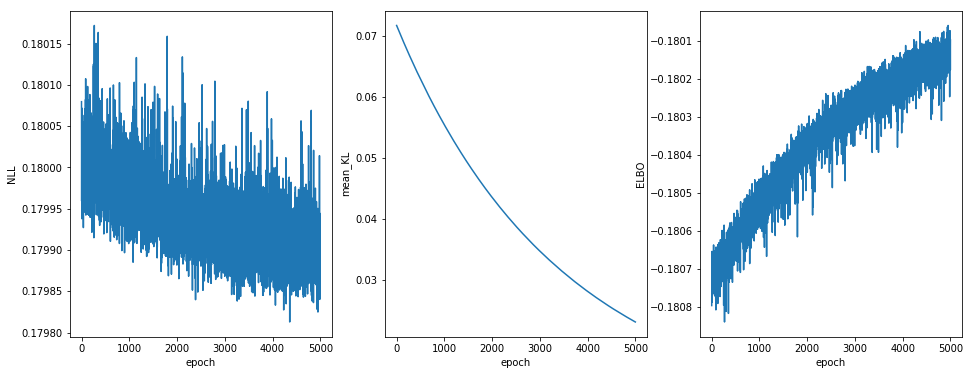

In [25]:
fig, ax_arr = plt.subplots(1, 3, figsize=(16, 6))

ax_arr[0].plot(h['epoch'], h['NLL'])
ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_xlabel('epoch')
ax_arr[1].plot(h['epoch'], h['mean_KL'])
ax_arr[1].set_ylabel('mean_KL')
ax_arr[1].set_xlabel('epoch')
ax_arr[2].plot(h['epoch'], h['ELBO'])
ax_arr[2].set_ylabel('ELBO')
ax_arr[2].set_xlabel('epoch')

plt.show();

Measure calibration performance:

In [26]:
### Temp-Scaling
temp_scaling_cal = TempScalingCalibrator(val_logits, val_target)
print("Calibrated using temperature T={:.3f}\n\n".format(temp_scaling_cal.T))

val_probs_temp = temp_scaling_cal.predict(val_logits)
test_probs_temp = temp_scaling_cal.predict(test_logits)

### MAtrix-Scaling
mat_scaling_cal = MatrixScalingCalibrator(val_logits, val_target)

val_probs_mat = mat_scaling_cal.predict(val_logits)
test_probs_mat = mat_scaling_cal.predict(test_logits)



### Uncalibrated model
val_probs = softmax(val_logits, axis=1)
test_probs = softmax(test_logits, axis=1)

val_ece = expected_calibration_error(val_probs, val_target)
test_ece = expected_calibration_error(test_probs, test_target)

val_nll = neg_log_likelihood(val_probs, val_target)
test_nll = neg_log_likelihood(test_probs, test_target)

## Temp-Scaling
# Validation set
val_nll_temp = neg_log_likelihood(val_probs_temp, val_target)
val_ece_temp = expected_calibration_error(val_probs_temp, val_target, bins=15)

# Test set
test_nll_temp = neg_log_likelihood(test_probs_temp, test_target)
test_ece_temp = expected_calibration_error(test_probs_temp, test_target, bins=15)


## Matrix-Scaling
# Validation set
val_nll_mat = neg_log_likelihood(val_probs_mat, val_target)
val_ece_mat = expected_calibration_error(val_probs_mat, val_target, bins=15)

# Test set
test_nll_mat = neg_log_likelihood(test_probs_mat, test_target)
test_ece_mat = expected_calibration_error(test_probs_mat, test_target, bins=15)



## Bayesian Matrix-Scaling calibrated
val_probs_bms = predict(val_logits, params)
test_probs_bms = predict(test_logits, params)

val_ece_bms = expected_calibration_error(val_probs_bms, val_target)
test_ece_bms = expected_calibration_error(test_probs_bms, test_target)

val_nll_bms = neg_log_likelihood(val_probs_bms, val_target)
test_nll_bms = neg_log_likelihood(test_probs_bms, test_target)

Calibrated using temperature T=2.437




In [27]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height.
    Taken from:
    'https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py'
    
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

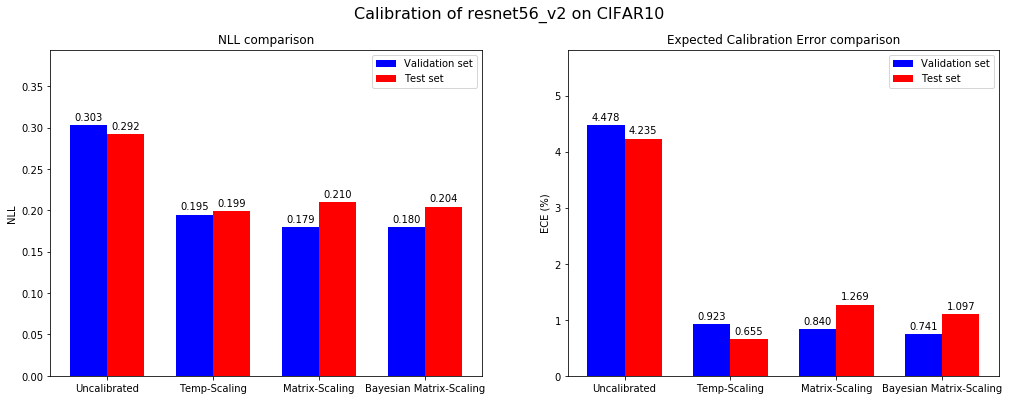

In [28]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
fig.suptitle('Calibration of resnet56_v2 on CIFAR10', fontsize=16)


ind = np.arange(4)
width = 0.35

ticks = ['Uncalibrated', 'Temp-Scaling', 'Matrix-Scaling', 'Bayesian Matrix-Scaling']


validation = np.array([val_nll, val_nll_temp, val_nll_mat, val_nll_bms])
test = np.array([test_nll, test_nll_temp, test_nll_mat, test_nll_bms])


rects1 = ax_arr[0].bar(ind, validation, width, color='b', label='Validation set')
rects2 = ax_arr[0].bar(ind+width, test, width, color='r', label='Test set')

ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_title('NLL comparison')
ax_arr[0].set_xticks(ind + width / 2)
ax_arr[0].set_xticklabels(ticks)
ax_arr[0].set_ylim([0, max(validation.max(), test.max())*1.3])
ax_arr[0].legend()

autolabel(rects1, ax_arr[0])
autolabel(rects2, ax_arr[0])


validation = np.array([val_ece, val_ece_temp, val_ece_mat, val_ece_bms])*100
test = np.array([test_ece, test_ece_temp, test_ece_mat, test_ece_bms])*100

rects1 = ax_arr[1].bar(ind, validation, width, color='b', label='Validation set')
rects2 = ax_arr[1].bar(ind+width, test, width, color='r', label='Test set')

ax_arr[1].set_ylabel('ECE (%)')
ax_arr[1].set_title('Expected Calibration Error comparison')
ax_arr[1].set_xticks(ind + width / 2)
ax_arr[1].set_xticklabels(ticks)
ax_arr[1].set_ylim([0, max(validation.max(), test.max())*1.3])
ax_arr[1].legend()

autolabel(rects1, ax_arr[1])
autolabel(rects2, ax_arr[1])

plt.show()

In [29]:
params

{'w_mean': array([[ 3.85807397e-01, -4.50999716e-02, -6.32463363e-02,
         -1.11205808e-01, -5.08353023e-02, -5.30539638e-02,
         -1.49664386e-02, -2.01688813e-03,  9.23805057e-03,
         -8.17314315e-02],
        [-5.78122542e-02,  3.99829610e-01, -1.12996793e-01,
         -4.35201173e-02, -4.83936343e-02, -6.68116441e-02,
         -5.10535034e-02, -5.51155135e-02, -2.35905784e-02,
          2.74258938e-02],
        [ 2.96302760e-03, -7.95695691e-02,  3.53238378e-01,
          1.17878488e-02, -3.42843960e-02,  2.25500438e-02,
         -6.74115042e-02, -2.01080739e-03, -4.16000955e-02,
         -1.16929665e-01],
        [-6.06642754e-02, -4.86055786e-02, -8.26072877e-02,
          3.52198683e-01, -2.45493149e-03,  3.46903268e-02,
         -5.60137284e-02, -2.98153870e-02,  9.78306427e-03,
          7.98752533e-03],
        [-2.61698655e-02,  1.27035524e-02, -3.78492043e-02,
         -7.74474869e-02,  4.11557670e-01, -4.34374693e-02,
         -2.82535548e-02, -1.66601593e-02,